In [1]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LassoCV , ElasticNetCV , RidgeCV
from sklearn.pipeline import Pipeline, FeatureUnion
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor as GBR
from xgboost import XGBRegressor as XGBR
# from xgboost import plot_importance
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR

from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA 
from sklearn.cross_decomposition import PLSRegression as  PLS
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 
import statsmodels.api as sm
import plotly.express as px
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.io as pio
pd.options.plotting.backend = 'plotly'
init_notebook_mode(connected=True)
pio.renderers.default = "notebook_connected"

import pandas as pd
import time

import pickle
import joblib

# Modeling
---
1. Dataset preprocessing
2. Model Pipeline & params
3. 결과 확인
4. 추가 데이터 predict

### 1. Data preprocessing
---
- 범주형 데이터 처리
    - status: Developed, Developing
- GDP per capita 추가
- 상관계수가 높은 4개의 피처에 대한 아웃라이어 제거

In [2]:
# 상관계수가 높은 4개의 피처에 대한 아웃라이어 제거까지 전처리
original = pd.read_csv("../datas/life_expectancy_data_fillna.csv")

def add_feature(original, filename=None):
    path = "../datas/worldbank_"
    original.columns = [cols.upper() for cols in original.columns.tolist()]
    
    if not filename == None:
        df = pd.read_csv(f"{path}{filename}.csv").groupby('Country Code').mean()
        df.drop(columns=['2016', '2017','2018','2019','2020'], axis=1, inplace=True)
        col_name = filename.upper()
        original[col_name] = [df.loc[original['COUNTRYCODE'][i]][str(original['YEAR'][i])] 
                              for i in range(len(original))]
    return original

# GDP per capita 데이터 추가
original = add_feature(original, "gdppercap")

# Nan값 GDP/POP으로 대체
original["GDPPERCAP"].fillna(original["GDP"] / original["POPULATION"], inplace=True)
original.columns = [cols.upper() for cols in original.columns.tolist()]

# 범주형 데이터 처리 - status: Developed, Developing
original = pd.get_dummies(original, columns=['STATUS'], drop_first=True)

# 기대수명에 대한 나머지 feature들의 상관관계
corr_matrix = original.drop(['COUNTRYCODE','ISO3166','COUNTRY','YEAR', 'REGION','INCOMEGROUP'], axis=1).corr()
corr_matrix['LIFE_EXPECTANCY'].sort_values(ascending=False)

# LIFE_EXPECTANCY와 높은 상관관계를 가지는 피처 순 정렬
top_corr = abs(corr_matrix['LIFE_EXPECTANCY']).sort_values(ascending=False)[1:5]
top_features = top_corr.index.tolist()

# lower fence, upper fence
region = original['REGION'].unique().tolist()
fence = {}

for r in region:
    fence[r] = {}
    
    for i, f in enumerate(top_features):
        q1 = np.percentile(original[original['REGION'] == r][top_features[i]].values, 25)
        q3 = np.percentile(original[original['REGION'] == r][top_features[i]].values, 75)
        iqr = q3 - q1

        upper_fence = ((iqr * 1.5) + q3).round(3)
        lower_fence = (q1 - (iqr * 1.5)).round(3)
                
        fence[r][f] = [lower_fence, upper_fence]
   
    
# 이상치 제거
region = original['REGION'].unique().tolist()
drop_list, target_idx = [], []

for r in region:
    target_df = original[original['REGION'] == r]
    
    for f in top_features:
        drop_idx = target_df[(target_df[f] < fence[r][f][0]) | 
                  (target_df[f] > fence[r][f][1])].index.tolist()
        
        drop_list.append(drop_idx)

# 제거 대상 인덱스
target_idx = set([idx for lst in drop_list for idx in lst])
original = original.drop(target_idx, axis=0)

print('top features:', top_features)

top features: ['INFANT_DEATHS', 'SCHOOLING', 'INCOME_COMPOSITION_OF_RESOURCES', 'ADULT_MORTALITY']


### 2. Pipeline & Params
---
- Linear Regression
- Decison Tree Regressor
- PCA + Linear Regression
- PLS Regression
- Gradient Boosting Regressor
- XGBoost Regressor
- Random Forest Regressor
- Support Vector Regressor
- Lasso
- Ridge
- Kernel Ridge Regression

In [3]:
pipe_linear = Pipeline([
                ('scl', StandardScaler()),
                ('poly', PolynomialFeatures()),
                 ('fit', LinearRegression())])
pipe_tree = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', DTR())])
pipe_lasso = Pipeline([
                ('scl', StandardScaler()),
                ('poly', PolynomialFeatures()),
                 ('fit', Lasso(random_state=13))])
pipe_ridge = Pipeline([
                ('scl', StandardScaler()),
                ('poly', PolynomialFeatures()),
                 ('fit', Ridge(random_state=13))])
pipe_pca = Pipeline([
                ('scl', StandardScaler()),
                ('pca', PCA()), 
                 ('fit',LinearRegression())])
pipe_pls = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', PLS())])
pipe_gbr = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', GBR())])
pipe_xgbr = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', XGBR(random_state=13))])
pipe_rfr = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', RFR(random_state=13))])
pipe_svr = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', SVR())])

pipe_KR = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', KernelRidge())])

In [4]:
grid_params_linear = [{
    "poly__degree" : np.arange(1,3), 
    "fit__fit_intercept" : [True, False], 
}]
grid_params_tree = [{
  }]
grid_params_lasso = [{
    "poly__degree" : np.arange(1,3),
    "fit__tol" : np.logspace(-5,0,10) ,
    "fit__alpha" : np.logspace(-5,1,10) ,     
                     }]
grid_params_ridge = [{
    "poly__degree" : np.arange(1,3),
    "fit__alpha" : np.linspace(2,5,10) ,
    "fit__solver" : [ "cholesky","lsqr","sparse_cg"] ,
    "fit__tol" : np.logspace(-5,0,10) ,
                     }]
grid_params_pca = [{
    "pca__n_components" : np.arange(2,8)
}]
grid_params_pls = [{
    "fit__n_components" : np.arange(2,8)
}]

min_samples_split_range = [0.5, 0.7, 0.9]
max_depth = [2, 4, 6, 8]

grid_params_gbr =[{
    "fit__max_features" : ["sqrt","log2"] ,
    "fit__loss" : ["ls","lad","huber","quantile"] , 
    "fit__max_depth" : max_depth,
    "fit__min_samples_split" : min_samples_split_range ,
}]
grid_params_xgbr =[{
    "fit__max_features" : ["sqrt","log2"] ,
    "fit__loss" : ["ls","lad","huber","quantile"] , 
    "fit__max_depth" : max_depth,
    "fit__min_samples_split" : min_samples_split_range ,
}]
grid_params_rfr =[{
    
}]
grid_params_svr =[{
    "fit__kernel" : ["rbf", "linear"] ,
    "fit__degree" : [2, 3, 5] , 
    "fit__gamma" : np.logspace(-5,1,10) ,
}]
grid_params_KR =[{
    "fit__kernel" : ["rbf","linear"] , 
    "fit__gamma" : np.logspace(-5,1,10) ,
}]

In [5]:
pipe = [
    pipe_linear, pipe_tree, pipe_lasso, pipe_ridge, pipe_pca ,
    pipe_pls, pipe_gbr, pipe_xgbr, pipe_rfr, pipe_svr, pipe_KR 
]

params = [
    grid_params_linear, grid_params_tree, grid_params_lasso, grid_params_ridge, grid_params_pca,
    grid_params_pls, grid_params_gbr, grid_params_xgbr, grid_params_rfr, grid_params_svr, grid_params_KR
]
jobs = -1
cv = KFold(n_splits=5 , shuffle=True, random_state=13)
# cv = ShuffleSplit(n_splits=5 , test_size=0.2, random_state=13)

grid_dict = {
    0: 'Linear Regression', 
    1: 'Decison Tree Regressor',
    2: 'Lasso',
    3: 'Ridge',
    4: 'PCA Regression', 
    5: 'PLS Regression',
    6: "Gradient Boosting Regressor",
    7: "XGBoost Regressor",
    8: "Random Forest Regressor",
    9: "Support Vector Regressor",
    10: "Kernel Ridge Regression"
            }

### Model Fit
---
- GridSearchCV
- 결과 시각화

In [6]:
X = original.drop(['COUNTRYCODE','ISO3166','COUNTRY','YEAR','LIFE_EXPECTANCY','REGION','INCOMEGROUP'], axis=1)
y = original['LIFE_EXPECTANCY']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=13)

#### GridSerachCV로 modeling 및 model save

In [8]:
model_rmse = {}
model_r2 = {}
model_best_params = {}
model_fit_times = {}

for idx , (param , model) in enumerate(zip(params , pipe)):
    start_time = time.time()
    search = GridSearchCV(model, param, scoring  = "neg_mean_squared_error", 
                          cv=cv, n_jobs=jobs, verbose=-1 )
    search.fit(X_train , y_train)
    y_pred = search.predict(X_test)
    model_rmse[grid_dict.get(idx)] = np.sqrt(mse(y_test, y_pred))  
    model_r2[grid_dict.get(idx)] = r2(y_test, y_pred)  
    model_best_params[grid_dict.get(idx)] = search.best_params_
    model_fit_times[grid_dict.get(idx)] = time.time() - start_time
    joblib.dump(search, f'models/{grid_dict.get(idx)}1.pkl') 
print("finish")

[19:00:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { loss, max_features, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


finish


#### Modeling results

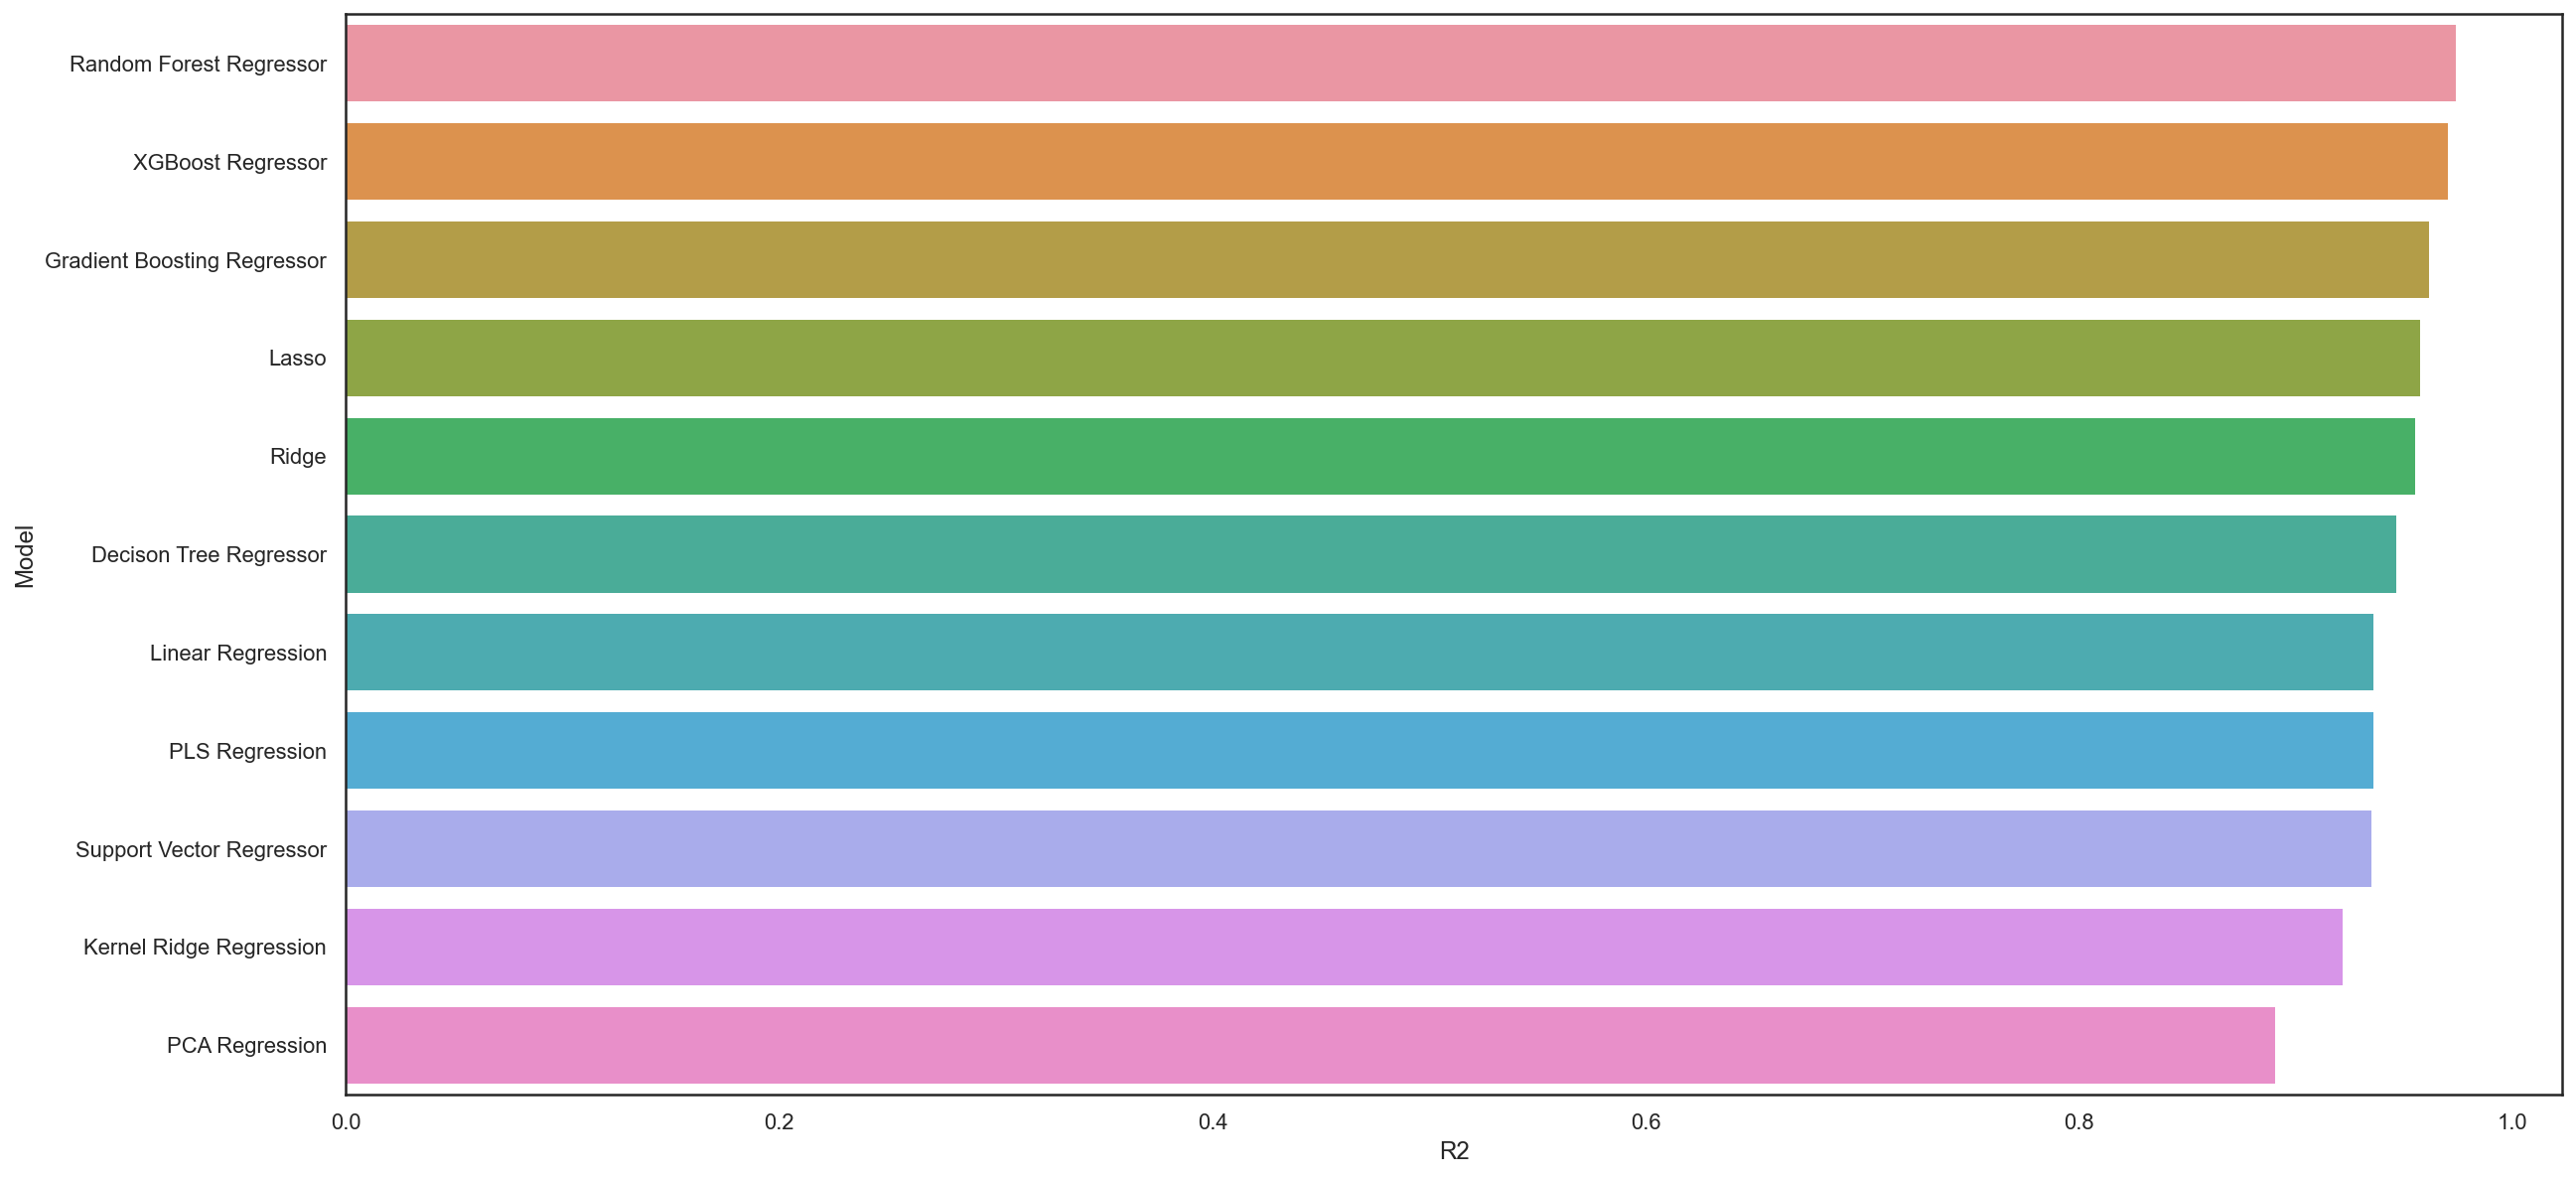

In [9]:
# Modeling 결과
fig ,ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale = 2)
output = pd.DataFrame([model_r2.keys() , model_r2.values(), model_rmse.values(), model_fit_times.values()], index = ["Model","R2", "RMSE", "Fit_times"]).T
output.sort_values(["R2"], ascending= False ,inplace=True)
output["Fit_times"] = [abs(_) for _ in output["Fit_times"]]
ax = sns.barplot(y="Model", x="R2", data=output)
plt.show()

In [10]:
output['R2'] = [float(_) for _ in output['R2']]
output['RMSE'] = [float(_) for _ in output['RMSE']]
output

,Model,R2,RMSE,Fit_times
8,Random Forest Regressor,0.974162,1.548812,3.299760
7,XGBoost Regressor,0.970760,1.647630,63.015429
6,Gradient Boosting Regressor,0.961985,1.878663,21.913717
2,Lasso,0.957876,1.977602,20.639435
3,Ridge,0.955366,2.035664,22.184153
1,Decison Tree Regressor,0.946942,2.219470,0.138630
0,Linear Regression,0.936309,2.431698,2.719789
5,PLS Regression,0.936057,2.436519,0.204454
9,Support Vector Regressor,0.935315,2.450599,21.252444
10,Kernel Ridge Regression,0.922043,2.690293,4.451245


In [11]:
px.scatter(output,x='RMSE', y='R2', color='Model', labels='Model')

In [12]:
# Model().get_params().keys()로 가능한 params 조회 가능
model_best_params

{'Linear Regression': {'fit__fit_intercept': True, 'poly__degree': 1},
 'Decison Tree Regressor': {},
 'Lasso': {'fit__alpha': 0.021544346900318822,
  'fit__tol': 0.0016681005372000592,
  'poly__degree': 2},
 'Ridge': {'fit__alpha': 5.0,
  'fit__solver': 'lsqr',
  'fit__tol': 0.005994842503189409,
  'poly__degree': 2},
 'PCA Regression': {'pca__n_components': 7},
 'PLS Regression': {'fit__n_components': 7},
 'Gradient Boosting Regressor': {'fit__loss': 'ls',
  'fit__max_depth': 8,
  'fit__max_features': 'sqrt',
  'fit__min_samples_split': 0.5},
 'XGBoost Regressor': {'fit__loss': 'ls',
  'fit__max_depth': 8,
  'fit__max_features': 'sqrt',
  'fit__min_samples_split': 0.5},
 'Random Forest Regressor': {},
 'Support Vector Regressor': {'fit__degree': 2,
  'fit__gamma': 0.021544346900318822,
  'fit__kernel': 'rbf'},
 'Kernel Ridge Regression': {'fit__gamma': 0.004641588833612777,
  'fit__kernel': 'rbf'}}

### 4. 추가 Predict
--- 

In [13]:
grid_dict = {
0: 'Linear Regression', 
1: 'Decison Tree Regressor',
2: 'Lasso',
3: 'Ridge',
4: 'PCA Regression', 
5: 'PLS Regression',
6: "Gradient Boosting Regressor",
7: "XGBoost Regressor",
8: "Random Forest Regressor",
9: "Support Vector Regressor",
10: "Kernel Ridge Regression"
        }

#### 2019년 한국 데이터

In [14]:
testset = pd.DataFrame(columns = original.columns)
new_dict = {'COUNTRYCODE': 'KOR',
            'YEAR':2019, 'STATUS_Developing': 0,
            'LIFE_EXPECTANCY':83,
            'GDP': 1646739.22, 
            'GDPPERCAP':31846.2, 
            'SCHOOLING':14, 
            'INFANT_DEATHS':3,
            'ADULT_MORTALITY':110,
            'INCOME_COMPOSITION_OF_RESOURCES':0.916,
            'POPULATION': 51709000,
           }
testset = testset.append(new_dict, ignore_index=True)
testset.fillna(original.mean(), inplace=True)
testset

,COUNTRYCODE,ISO3166,COUNTRY,YEAR,LIFE_EXPECTANCY,ADULT_MORTALITY,INFANT_DEATHS,ALCOHOL,PERCENTAGE_EXPENDITURE,HEPATITIS_B,...,GDP,POPULATION,THINNESS_1_19_YEARS,THINNESS_5_9_YEARS,INCOME_COMPOSITION_OF_RESOURCES,SCHOOLING,REGION,INCOMEGROUP,GDPPERCAP,STATUS_Developing
0,KOR,431.09992,NaN,2019,83,110,3,4.953657,5.970516,74.39988,...,1646739.22,51709000,7.745723,4.972702,0.916,14,NaN,NaN,31846.2,0


In [17]:
# 저장한 모델을 불러와 predict하는 함수
def model_predict(model_idx, test_df):
    saved_model = joblib.load(f"models/{grid_dict.get(model_idx)}1.pkl")
    X_pr = test_df[X.columns]
    y_pr = test_df['LIFE_EXPECTANCY']

    y_pred = saved_model.predict(X_pr)
    print(f"{grid_dict.get(model_idx)} | 예측 기대 수명:{y_pred.mean().round(2)} / RMSE:, {np.sqrt(mse(y_pr, y_pred)).round(2)}")
    r2_score = r2(y_pr, y_pred)
    if r2_score is True:
        print("R2:", r2_score)

In [18]:
for idx, model_idx in enumerate(range(len(grid_dict))):
    model_predict(model_idx,testset)

Linear Regression | 예측 기대 수명:81.35 / RMSE:, 1.65
Decison Tree Regressor | 예측 기대 수명:76.9 / RMSE:, 6.1
Lasso | 예측 기대 수명:79.98 / RMSE:, 3.02
Ridge | 예측 기대 수명:78.78 / RMSE:, 4.22
PCA Regression | 예측 기대 수명:77.01 / RMSE:, 5.99
PLS Regression | 예측 기대 수명:80.9 / RMSE:, 2.1
Gradient Boosting Regressor | 예측 기대 수명:73.58 / RMSE:, 9.42
XGBoost Regressor | 예측 기대 수명:80.44999694824219 / RMSE:, 2.55
Random Forest Regressor | 예측 기대 수명:78.47 / RMSE:, 4.53
Support Vector Regressor | 예측 기대 수명:80.62 / RMSE:, 2.38
Kernel Ridge Regression | 예측 기대 수명:83.41 / RMSE:, 0.41


### 5. Model results visualization
----

In [19]:
data_df = pd.concat([original[X.columns], original['LIFE_EXPECTANCY']], axis=1)

X = data_df[X.columns]
y = data_df['LIFE_EXPECTANCY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=13)

data_df['split'] = 'train'
data_df.loc[X_test.index, 'split'] = 'test'

In [20]:
# reg plot 함수
def reg_plotly(model_idx):
    model = joblib.load(f"models/{grid_dict.get(model_idx)}1.pkl")
    model.fit(X_train, y_train)
    y_pred = model.predict(X)
    data_df['prediction'], data_df['y_test'], data_df['y_train']= y_pred, y_test, y_pred

    fig = px.scatter(
            data_df, x=data_df['LIFE_EXPECTANCY'], y=data_df['prediction'],
            marginal_y='histogram', color='split', title=f"{grid_dict.get(model_idx)} Model", 
            color_discrete_sequence=['red', 'cornflowerblue']) #mediumaquamarine

    fig.update_traces(histnorm='probability', selector={'type':'histogram'})

    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=y.min(), y0=y.min(),
        x1=y.max(), y1=y.max()
    )
    fig.update_layout(font_size=14, width=1000, height=600, template='plotly_white')
    fig.show()

In [21]:
reg_plotly(0)

In [22]:
reg_plotly(8)